# Exercises

In [2]:
import numpy as np
import scipy
import scipy.stats
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

%matplotlib inline 
plt.rcParams['figure.figsize'] = [10, 5]
from ipywidgets import interact
import ipywidgets as widgets

### Code for data generation

In [32]:
track_length = 200. # the length of our linear track (eg in centimeter)
average_firing_rate = 5 # the peak firing rate, averaged across the population 
n_cells = 100 # how many cells we are recording
pf_centers = np.random.rand(n_cells) * track_length # the centers of the place fields for all cells drawn randomly with a uniform distribution on the track
pf_size = np.random.gamma(10, size=n_cells) # the size (width) of the place fields, drawn randomly from a gamma distribution 
pf_rate = np.random.exponential(scale=average_firing_rate, size=n_cells) # the peak firing rate for each cell, drawn from an exponential distribution
# --------------
bins = np.arange(0., 200.)
true_firing_rate_maps = np.zeros((n_cells, len(bins)))
for i in range(n_cells):
    true_firing_rate_maps[i,:] = pf_rate[i] * np.exp(-((bins-pf_centers[i])**2)/(2*pf_size[i]**2))

In [33]:
# GENERATE TRAJECTORY

n_runs = 10
use_stops = False
av_running_speed = 10 # the average running speed (in cm/s)
fps = 10 # the number of "video frames" per second 
running_speed_a = np.random.chisquare(10, size=n_runs) # running speed in the two directions
running_speed_b = np.random.chisquare(10, size=n_runs) 

stopping_time_a = np.random.chisquare(15, size=n_runs) # the time the mouse will spend at the two ends of the track
stopping_time_b = np.random.chisquare(15, size=n_runs)

x = np.array([])


for i in range(n_runs):
    stop1 = np.ones((int(stopping_time_a[i]*fps),)) * 0.
    run_length = len(bins) * fps / running_speed_a[i]
    run1 = np.linspace(0., float(len(bins)-1), int(run_length))
    stop2 = np.ones((int(stopping_time_b[i]*fps),)) * (len(bins)-1.)
    run_length = len(bins) * fps / running_speed_b[i]
    run2 = np.linspace(len(bins)-1., 0., int(run_length))
    if use_stops:
        x = np.concatenate((x, stop1, run1, stop2, run2))
    else:
         x = np.concatenate((x, run1, run2))
t = np.arange(len(x))/fps

In [5]:
np.random.seed(0) # for reproducibility

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
noise_firing_rate = 0.1 # the baseline noise firing rate
spikes = []

for i in range(n_cells):
    inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + noise_firing_rate
    spikes_loc = np.random.poisson(inst_rate/sampling_rate)
    sp = np.argwhere(spikes_loc)
    t_sp = t_sampling[sp]
    spikes.append(t_sp) # spike times for each cell


In [6]:
print("Spikes in the first three cells:")
print(spikes[0].shape, spikes[1].shape, spikes[2].shape) # print the number of spikes for the first three cells

# we compute the poistion at which each spike was emitted
spike_positions = [np.interp(s, t, x) for s in spikes]
space_bins = np.arange(0., track_length, 5.) # binning in bins of 5 cms

# we compute histograms for each cell
spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
spikes_hist = np.asarray(spikes_hist)

# we also need an "occupancy histogram" in order to normalize the firing rates maps 
occupancy = np.histogram(x, space_bins)[0] /  fps

firing_rate_maps = spikes_hist / occupancy

# print(firing_rate_maps.shape) # 100 cells 39 bins

Spikes in the first three cells:
(645, 1) (546, 1) (212, 1)


In [7]:
spikes_count= [np.histogram(s,t)[0] for s in spikes]
spikes_count = np.asarray(spikes_count).T # we transpose the matrix to have the more familiar (samples x features) shape
print("Shape of the spikes count matrix: ", spikes_count.shape)
# samples x features
# time bins x cells


Shape of the spikes count matrix:  (5810, 100)


## Exercise 1
---

You can find below the code that was used to generate the activity of place cells on a linear track.
Use the code and the decoding procedure you learned about in the lesson to explore how different features of the data impact our ability to decode position.
In particular:

A - Try to use different fractions of our data samples. How does the median error change when the the number of available sample gets larger? You do not need to re-generate any data, just randomly sub-sample the data to different fractions.

In [157]:
'''
Description of the loop in code:
For each time bin/sample t_bin, looks at the spike counts of all neurons, 
and compute the posterior probability for each possible position bin i 
using the precomputed firing rates.

t_bin → which time slice are we decoding?
i → for that time slice, which position bin gives the highest likelihood given the spike pattern?
'''

# fractions = [0.1, 0.25, 0.5, 0.75, 1.0]
fractions = np.arange(0, 1.1, 0.1)# Adjusted fractions for more granularity
errors = []
from scipy.stats import poisson

# Loop over fractions
for frac in fractions:
    cutoff = int(frac * len(spikes_count))  # match decoding length
    # print("alo", cutoff)
    x_sub = x[:cutoff]
    t_sub = t[:cutoff]
    sc_sub = spikes_count[:cutoff]

    x_decoded = np.zeros_like(x_sub)

    for t_bin in tqdm(range(len(t_sub))):
        if np.sum(sc_sub[t_bin, :]) > 0:
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = np.sum(
                    poisson.logpmf(sc_sub[t_bin, :], firing_rate_maps[:, i] / fps) + 1e-15
                )
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan
    
    
    # Compute RMSE
    mse = (x_sub - x_decoded) ** 2
    medmse = np.nanmedian(mse)  # Use nanmean to ignore NaNs
    errors.append(medmse)


0it [00:00, ?it/s]
c:\Users\ptrso\.conda\envs\NRA\Lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
100%|██████████| 6409/6409 [00:33<00:00, 190.32it/s]


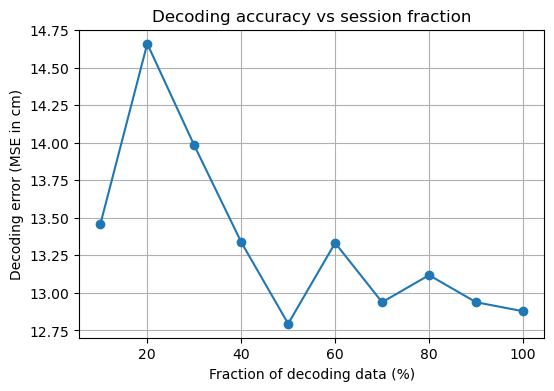

In [158]:
# Plot results
plt.figure(figsize=(6, 4))
plt.plot(np.array(fractions)*100, errors, marker='o')
plt.xlabel("Fraction of decoding data (%)")
plt.ylabel("Decoding error (MSE in cm)")
plt.title("Decoding accuracy vs session fraction")
plt.grid(True)
plt.show()


We decoded position using increasing fractions of the session (10–100%) with fixed tuning curves. What we expect is the error to decrease with more data. From the graph we observe this drop in accordance with our expectation although there are some fluctuations. The small fluctuations across session fractions can be explained partly by the randomness in the generated trajectory and spike trains. Some segments may be easier or harder to decode depending on how well they cover space or align with place field activity by chance.

### part B)
How many place cells do we need to reliably decode position? Try to re-do the decoding using only 10 cell, then 20, and so on. How does the median error change? Does it reach an asymptote? (Also in this case, you do not need to re-generate the data, you can just select a random subset of cells each time) 

In [ ]:
from scipy.stats import poisson

cell_counts = list(range(10, 101, 10))
print("Cell counts for decoding: ", cell_counts)
errors_c = []

for n in tqdm(cell_counts):
    np.random.seed(0)  # for reproducibility
    # Randomly select n cells
    selected_cells = np.random.choice(spikes_count.shape[1], size=n, replace=False)

    # Subset spikes and spike counts
    spikes_subset = [spikes[i] for i in selected_cells]
    spikes_count_subset = spikes_count[:, selected_cells]

    # Compute tuning curves
    spike_pos_subset = [np.interp(s, t, x) for s in spikes_subset]
    spikes_hist = [np.histogram(s, space_bins)[0] for s in spike_pos_subset]
    spikes_hist = np.asarray(spikes_hist)
    occupancy = np.histogram(x, space_bins)[0] / fps
    firing_rate_maps = spikes_hist / occupancy  # shape (n_cells, n_bins)

    # Decode full session
    true_x = x[:-1] # get rid of last timepoint to have same length as binned spikes
    decoding_times = t[:-1]

    x_decoded = np.zeros_like(true_x)   
    
    for t_bin in range(len(spikes_count_subset)):
        if np.sum(spikes_count_subset[t_bin, :]) > 0:
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = np.sum(
                    poisson.logpmf(spikes_count_subset[t_bin, :], firing_rate_maps[:, i] / fps) + 1e-15
                )
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan

    # Compute median squared error
    mse = (true_x - x_decoded) ** 2
    med_mse = np.nanmedian(mse)
    errors_c.append(med_mse)


Cell counts for decoding:  [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


100%|██████████| 10/10 [01:56<00:00, 11.62s/it]


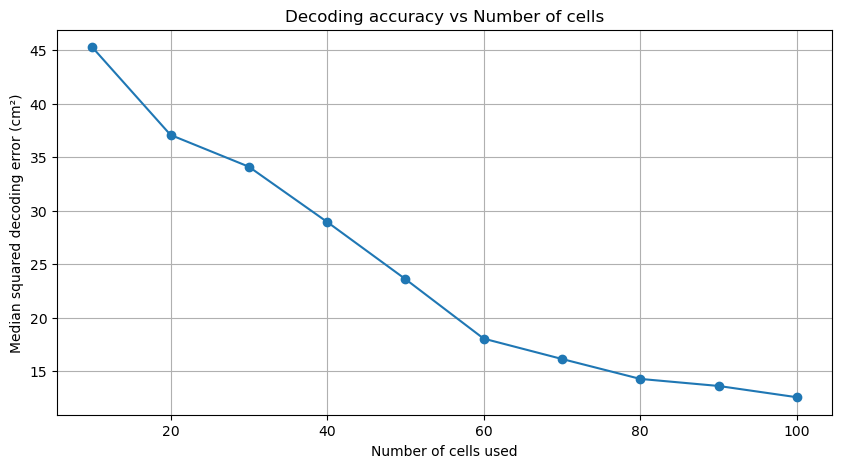

In [16]:
plt.plot(cell_counts, errors_c, marker='o')
plt.xlabel("Number of cells used")
plt.ylabel("Median squared decoding error (cm²)")
plt.title("Decoding accuracy vs Number of cells")
plt.grid()
plt.show()


Decoded the full session using increasing number of randomly selected place cells to simulate a realistic scenario where we do not know which cells are bad and allow generalization. The median error drops steeply for 10-60 cells used and then began to level off above 70, suggesting that ~80–100 cells are sufficient for reliable decoding in this dataset. We can conclude that the error is close to reaching an asymptote.

### part C 
Generate new data using the code below, changing the firing rate noise (changing the value of the variable `noise firing_rate`). How does this noise impact the decoding? 

In [52]:
np.random.seed(0) # for reproducibility

sampling_rate = 10000.
t_sampling = np.arange(0, t[-1], 1. / sampling_rate)
x_sampling = np.floor(np.interp(t_sampling, t, x))
errors_n = [] # to store median squared errors for different noise firing rates

noise_frs = [0.01, 0.1, 0.2, 0.5, 1.0, 2.0] # noise firing rates for each cell

for nfr in tqdm(noise_frs):
    spikes = []  # reset spikes for each noise firing rate
    for i in range(n_cells):
        inst_rate = true_firing_rate_maps[i,x_sampling.astype(np.int32)] + nfr
        spikes_loc = np.random.poisson(inst_rate/sampling_rate)
        sp = np.argwhere(spikes_loc)
        t_sp = t_sampling[sp]
        spikes.append(t_sp) # spike times for each cell
    
    # Get firing rate maps for the current noise firing rate
    spike_positions = [np.interp(s, t, x) for s in spikes]
    space_bins = np.arange(0., track_length, 5.) 
    spikes_hist= [np.histogram(s, space_bins)[0] for s in spike_positions]
    spikes_hist = np.asarray(spikes_hist)
    occupancy = np.histogram(x, space_bins)[0] /  fps
    firing_rate_maps = spikes_hist / occupancy

    # Here spike_counts changes as well, so we need to recompute it
    spikes_count= [np.histogram(s,t)[0] for s in spikes]
    spikes_count = np.asarray(spikes_count).T

    true_x = x[:-1]
    decoding_times = t[:-1]
    x_decoded = np.zeros_like(true_x)   

    for t_bin in range(len(spikes_count)):
        if np.sum(spikes_count[t_bin, :]) > 0:
            posterior = np.empty(firing_rate_maps.shape[-1])
            for i in range(len(posterior)):
                posterior[i] = np.sum(
                    poisson.logpmf(spikes_count[t_bin, :], firing_rate_maps[:, i] / fps) + 1e-15
                )
            x_decoded[t_bin] = space_bins[np.argmax(posterior)]
        else:
            x_decoded[t_bin] = np.nan

    # Compute median squared error
    mse = (true_x - x_decoded) ** 2
    med_mse = np.nanmedian(mse)
    errors_n.append(med_mse)

100%|██████████| 6/6 [04:20<00:00, 43.39s/it]


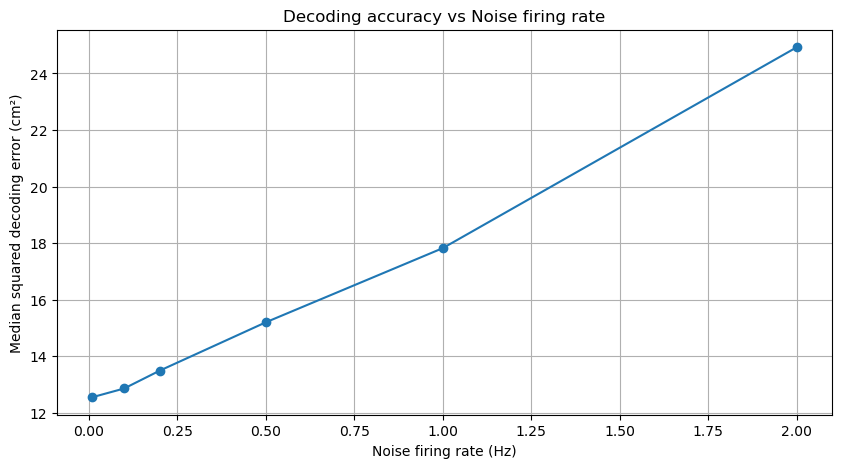

In [54]:
plt.plot(noise_frs, errors_n, marker='o')
plt.xlabel("Noise firing rate (Hz)")
plt.ylabel("Median squared decoding error (cm²)")
plt.title("Decoding accuracy vs Noise firing rate")
plt.grid()
plt.show()


We simulated spike trains using increasing levels of baseline noise in firing rate (0–2 Hz) and evaluated how decoding accuracy was affected. As expected, the median squared error increased with noise, since random spiking degraded the reliability of position-specific firing patterns. The results confirm that even modest noise can impair decoding performance.